# Area-Average Sample Code

This code demonstrates how to use the "area_average" function, utilizing MetPy and the Unidata THREDDS server to access real-time GFS data and calculate the area-average of a vorticity field.

First, import the necessary libraries:

In [1]:
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import metpy.calc as calc
from metpy.units import units

import matplotlib.pyplot as plt
import cartopy
from cartopy import crs as ccrs
from cartopy import feature as cfeat
from cartopy import util as cu

from area_average import area_average

Specify a GFS initialization time, and then access it using OPENDAP. Note that the file is in grib2 format, but the underlying netCDF-Java library translates this to netCDF format as we are reading this from an OpenDAP server (THREDDS).

In [2]:
run_date = "20190106"
init = "1200"

url = f"http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_{run_date}_{init}.grib2"
data = xr.open_dataset(url)

print(data)

<xarray.Dataset>
Dimensions:                                                                     (altitude_above_msl: 3, depth_below_surface_layer: 4, depth_below_surface_layer_bounds_1: 2, height_above_ground: 1, height_above_ground1: 2, height_above_ground2: 1, height_above_ground3: 3, height_above_ground4: 3, height_above_ground_layer: 1, height_above_ground_layer1: 1, height_above_ground_layer1_bounds_1: 2, height_above_ground_layer_bounds_1: 2, isobaric: 31, isobaric1: 19, isobaric2: 1, isobaric3: 21, isobaric4: 26, isobaric5: 17, lat: 721, lon: 1440, potential_vorticity_surface: 2, pressure_difference_layer: 1, pressure_difference_layer1: 1, pressure_difference_layer1_bounds_1: 2, pressure_difference_layer2: 2, pressure_difference_layer2_bounds_1: 2, pressure_difference_layer_bounds_1: 2, sigma: 1, sigma_layer: 4, sigma_layer_bounds_1: 2, time: 92, time1: 92, time1_bounds_1: 2, time2: 93)
Coordinates:
  * lat                                                                        

There's a lot of variables, but we want to calculate vorticity, so we'll choose the relevant variables (u & v wind), subset spatially over North America, and we'll specify 500-hPa as the desired pressure level. For simplicity, we'll use the first time step in the model run.

We'll also assign units to the u & v arrays using metpy's units module - typically this is in m/s, so we will specify it as such. While not necessary for calculation purposes, we will also load geopotential height for eventual plotting.

In [3]:
#Subset data to only the first time step, using xarray's "isel" functionality
data_subset = data.isel(time2=0)

#Subset data over North America - this domain will also be used for the plot
lonW,lonE,latS,latN = [-150+360, -45+360, 15, 70]
data_subset = data_subset.sel(lat=slice(latN,latS),lon=slice(lonW,lonE))

#pressure level in Pascals
pres_level = 85000.0

#Retrieve u & v wind
u = data_subset['u-component_of_wind_isobaric'].sel(isobaric=pres_level)
v = data_subset['v-component_of_wind_isobaric'].sel(isobaric=pres_level)
g = data_subset['Geopotential_height_isobaric'].sel(isobaric=pres_level)

#Load u & v wind into memory & assign units
u = u.values * units('m/s')
v = v.values * units('m/s')
g = g.values * units('m')

Now we'll use MetPy's available calculations to compute relative vorticity.

In [4]:
#Retrieve lat & lon from dataset
lat = data_subset.lat.values
lon = data_subset.lon.values

#calculate grid deltas, since GFS grid uses equal latitude & longitude spacing
dx, dy = calc.lat_lon_grid_deltas(lon,lat)

#Calculate vorticity
vort = calc.vorticity(u,v,dx,dy)
print(vort)

[[ 1.97096620e-05  1.16003526e-05  1.81577299e-05 ...  1.01237956e-05   1.33322753e-05  1.71916848e-05] [ 1.83880862e-05  3.21783036e-05  3.92533014e-05 ... -2.63867588e-06  -2.95904985e-06 -5.73774752e-06] [ 5.18512893e-05  4.49209681e-05  3.57542428e-05 ...  3.79890463e-06   2.95157686e-06  2.82373910e-06] ... [ 4.13687310e-06  4.49661015e-06  4.66969447e-06 ... -1.30384811e-05  -1.23665495e-05 -1.07749233e-05] [ 3.63666747e-06  4.53600786e-06  3.42399370e-06 ... -1.15021455e-05  -1.01091737e-05 -1.01485662e-05] [ 1.82404559e-06  5.31757108e-06  2.17103606e-06 ... -9.79932082e-06  -8.92535905e-06 -1.15449773e-05]] / second


First we'll make a plot of what the vorticity field looks like without spatial averaging performed using Cartopy.

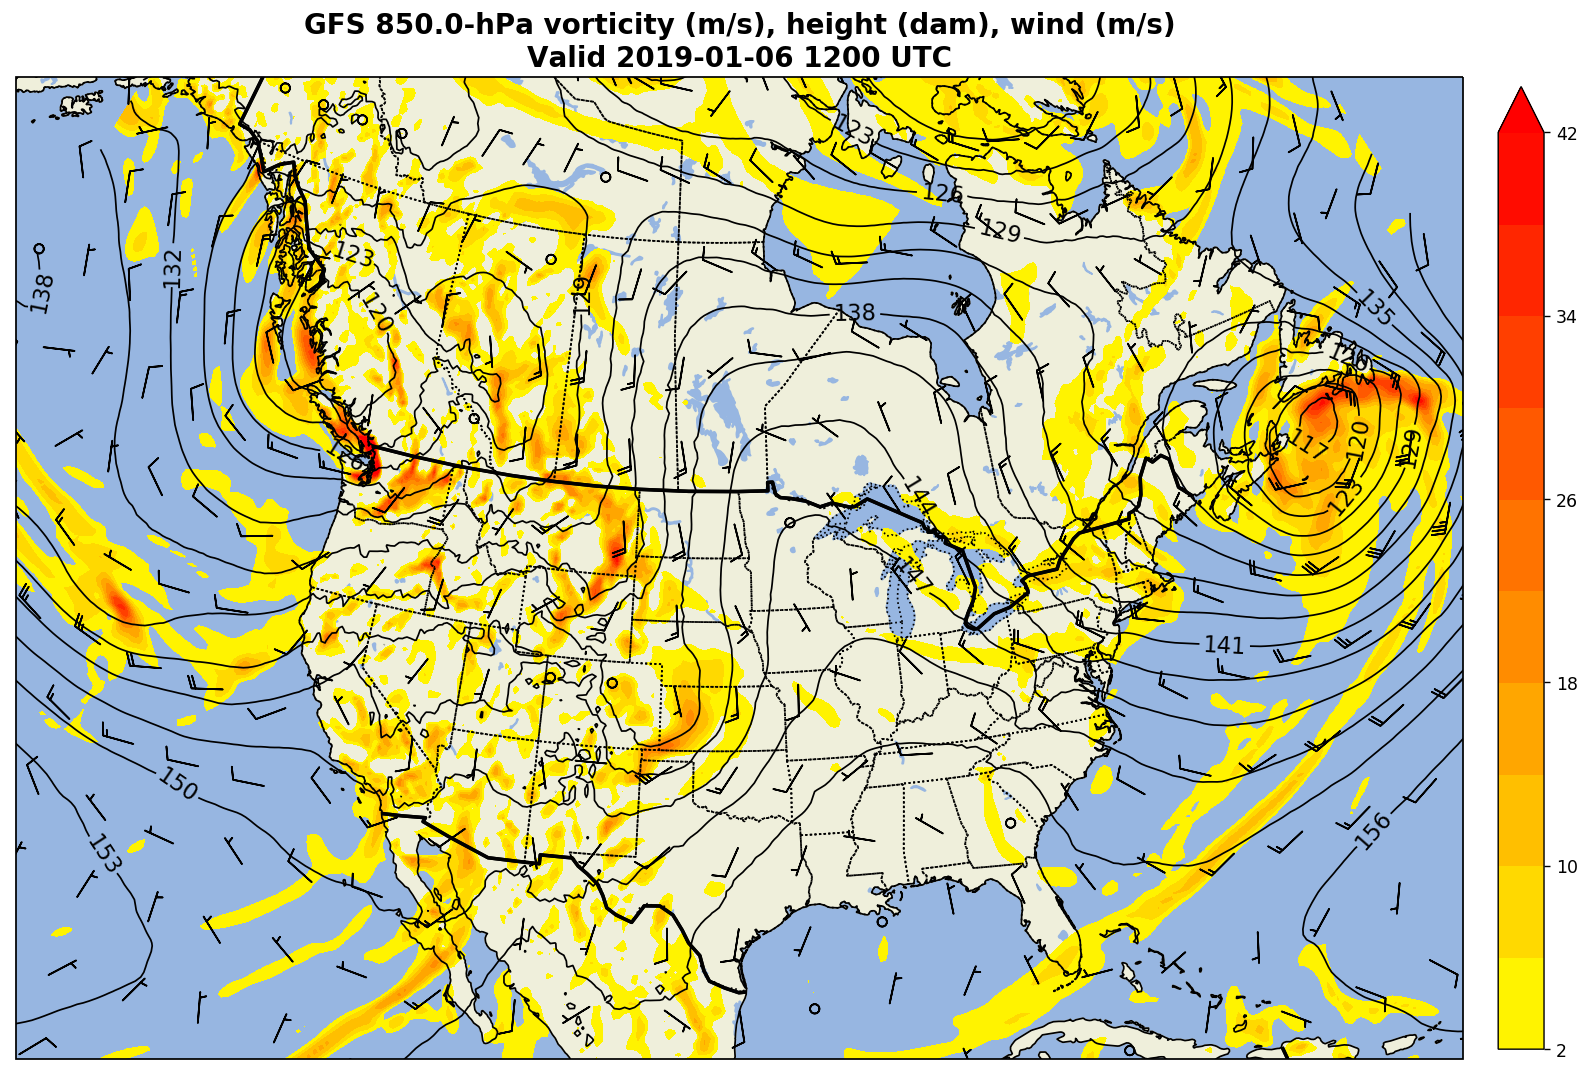

In [5]:
#======================================================================================
# 0. Create map projection
#======================================================================================

#Create a Lambert conformal projection object, centered over the US
lon1 = -98.5
lat1 = 38.
slat = 38.
proj_lcc = ccrs.LambertConformal(central_longitude=lon1,
                             central_latitude=lat1,
                             standard_parallels=[slat])

#Create figure and axis
fig = plt.figure(figsize=(18,12),dpi=125)
ax = fig.add_subplot(1,1,1,projection=proj_lcc)
ax.set_extent([lonW+18,lonE-18,latS+4,latN-7])
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeat.BORDERS, linewidths=2, edgecolor='black')
state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                         name='admin_1_states_provinces_lines',
                         scale='50m', facecolor='none')
ax.add_feature(state_boundaries, linestyle=':',linewidths=1,edgecolor='black')

#Add geography features (coastlines, countries, states, etc.)
ax.add_feature(cfeat.BORDERS, linewidths=2, edgecolor='black')
land_mask = cfeat.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='face',
                                    facecolor=cfeat.COLORS['land'])
sea_mask = cfeat.NaturalEarthFeature('physical', 'ocean', '50m',
                                    edgecolor='face',
                                    facecolor=cfeat.COLORS['water'])
lake_mask = cfeat.NaturalEarthFeature('physical', 'lakes', '50m',
                                    edgecolor='face',
                                    facecolor=cfeat.COLORS['water'])
ax.add_feature(sea_mask,zorder=0)
ax.add_feature(land_mask,zorder=0)
ax.add_feature(lake_mask,zorder=0)

state_borders = cfeat.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',
                                    scale='50m', facecolor='none')
ax.add_feature(state_borders, linestyle='dotted', edgecolor='black',zorder=4)

#======================================================================================
# 1. Relative vorticity in filled contours
#======================================================================================

#Plot cyclonic vorticity, scaled to 10**5
fint = np.arange(2,46,4)
vort_plot = (vort*10**5).m

CF = ax.contourf(lon,lat,vort_plot,levels=fint,cmap=plt.get_cmap('autumn_r'),transform=ccrs.PlateCarree(),extend='max')
cbar = fig.colorbar(CF,shrink=0.85,pad=0.02)

#======================================================================================
# 2. 850-hPa Heights in solid contours
#======================================================================================

#Convert height from m to dam
hght = g.to('decam')

#Plot height contours & labels
cint = np.arange(60,180,3)
CS = ax.contour(lon,lat,hght,cint,linewidths=1,colors='black',linestyles='solid',transform=ccrs.PlateCarree())
ax.clabel(CS, inline=1, linewidths=3, fontsize=13,fmt='%.0f')

#======================================================================================
# 3. 850-hPa wind barbs
#======================================================================================

#Plot wind barbs
skip = 15
ax.barbs(lon[::skip], lat[::skip], u.m[::skip,::skip], v.m[::skip,::skip], transform=ccrs.PlateCarree(), length=6,zorder=4)

#======================================================================================
# 4. Add plot title & save figure
#======================================================================================

#Create plot title
valid_time = data_subset.reftime.values
valid_time_str = dt.datetime.strftime(pd.to_datetime(valid_time),'%Y-%m-%d %H%M UTC')
title1 = f"GFS {pres_level/100.0}-hPa vorticity (m/s), height (dam), wind (m/s)"
title2 = f"Valid {valid_time_str}"
plt.title(title1+"\n"+title2,fontsize=16,fontweight='bold')

#Save & close figure
plt.show()
plt.close()

## Calculate area-averaged vorticity

Now that we have a regular vorticity field, let's use the "vort_avg" function to calculate 700km area-averaged vorticity.

In [6]:
#Specify radius to perform area-averaging over
radius = 500.0 * units('kilometers')

#Apply this to all variables being plotted
vort_avg = area_average(vort,radius,lon,lat); print("Finished area-averaging vort")
u_avg = area_average(u,radius,lon,lat); print("Finished area-averaging u")
v_avg = area_average(v,radius,lon,lat); print("Finished area-averaging v")
g_avg = area_average(g,radius,lon,lat); print("Finished area-averaging g")

Finished area-averaging vort
Finished area-averaging u
Finished area-averaging v
Finished area-averaging g


Now let's plot a similar plot, but this time of the area-averaged variables:

/kt11/ktyle/anaconda3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1825: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/kt11/ktyle/anaconda3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1825: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


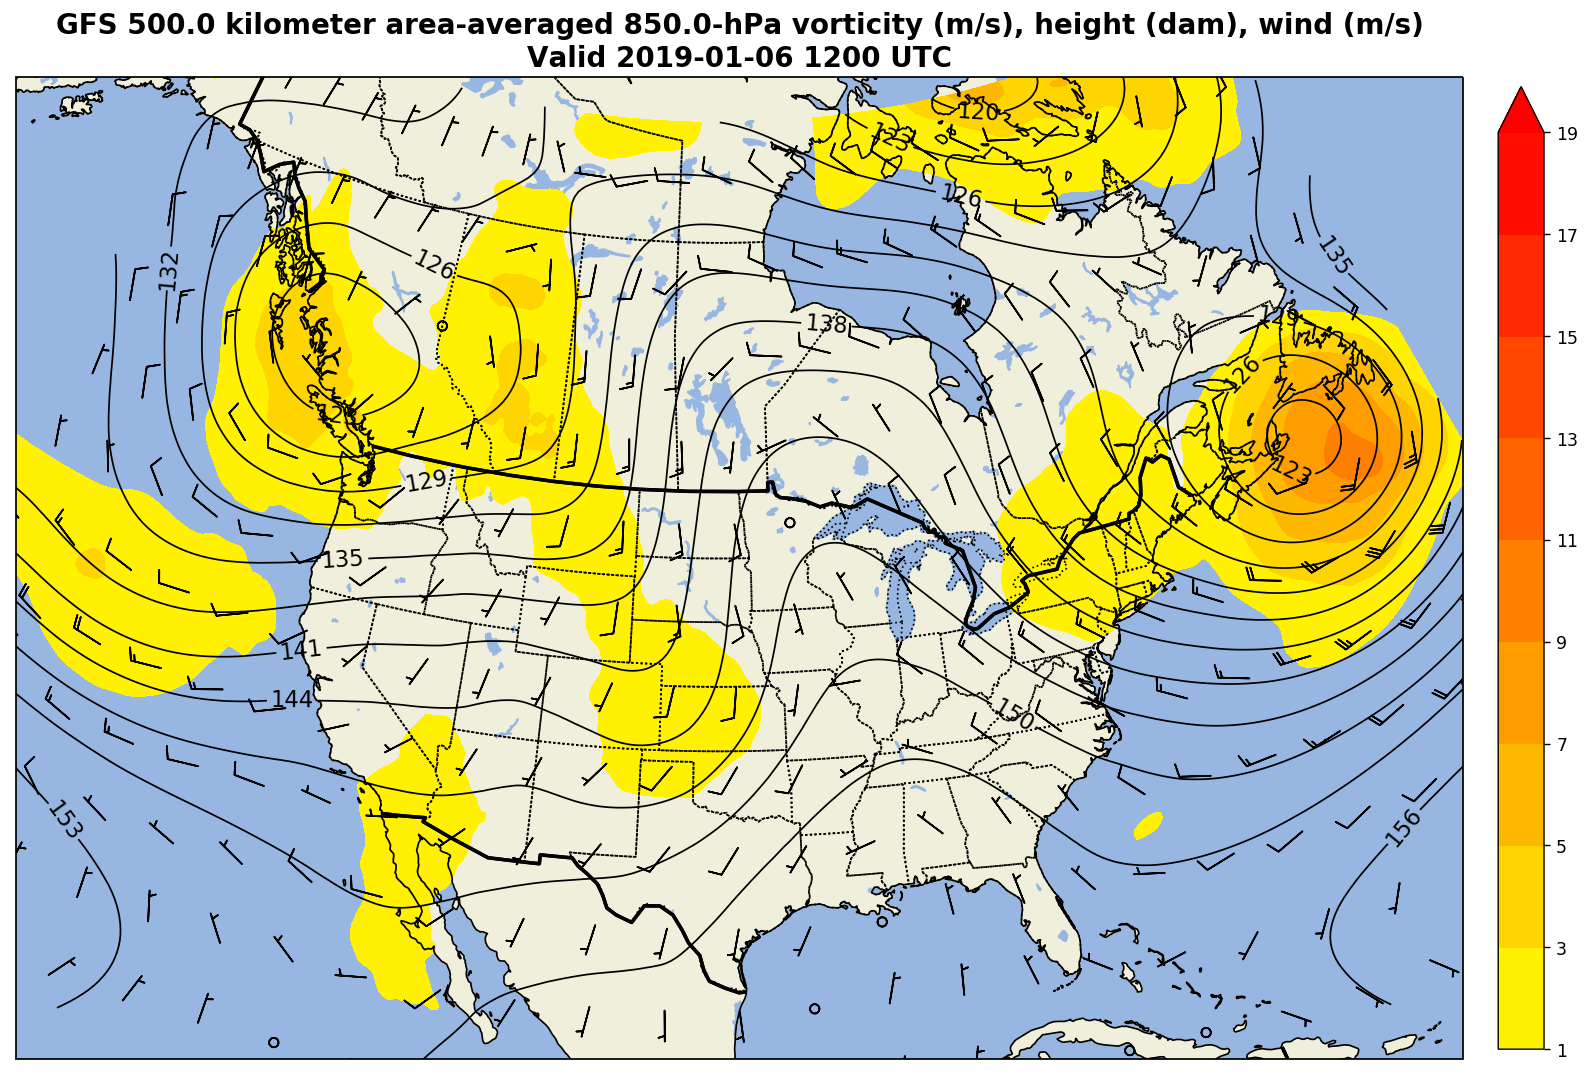

In [7]:
#======================================================================================
# 0. Create map projection
#======================================================================================

#Create figure and axis
fig = plt.figure(figsize=(18,12),dpi=125)
ax = fig.add_subplot(1,1,1,projection=proj_lcc)
ax.set_extent([lonW+18,lonE-18,latS+4,latN-7])
ax.coastlines(resolution='50m', color='black')
ax.add_feature(cfeat.BORDERS, linewidths=2, edgecolor='black')
state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                         name='admin_1_states_provinces_lines',
                         scale='50m', facecolor='none')
ax.add_feature(state_boundaries, linestyle=':',linewidths=1,edgecolor='black')

#Add geography features (coastlines, countries, states, etc.)
ax.add_feature(cfeat.BORDERS, linewidths=2, edgecolor='black')
land_mask = cfeat.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='face',
                                    facecolor=cfeat.COLORS['land'])
sea_mask = cfeat.NaturalEarthFeature('physical', 'ocean', '50m',
                                    edgecolor='face',
                                    facecolor=cfeat.COLORS['water'])
lake_mask = cfeat.NaturalEarthFeature('physical', 'lakes', '50m',
                                    edgecolor='face',
                                    facecolor=cfeat.COLORS['water'])
ax.add_feature(sea_mask,zorder=0)
ax.add_feature(land_mask,zorder=0)
ax.add_feature(lake_mask,zorder=0)

state_borders = cfeat.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',
                                    scale='50m', facecolor='none')
ax.add_feature(state_borders, linestyle='dotted', edgecolor='black',zorder=4)

#======================================================================================
# 1. Relative vorticity in filled contours
#======================================================================================

#Plot cyclonic vorticity, scaled to 10**5
#Note the contour interval here is smaller - area-averaged quantities tend to have smaller magnitudes than
#prior to applying area-averaging
fint = np.arange(1,20,2)
vort_plot = (vort_avg*10**5).m

CF = ax.contourf(lon,lat,vort_plot,levels=fint,cmap=plt.get_cmap('autumn_r'),transform=ccrs.PlateCarree(),extend='max')
cbar = fig.colorbar(CF,shrink=0.85,pad=0.02)

#======================================================================================
# 2. 850-hPa Heights in solid contours
#======================================================================================

#Convert height from m to dam
hght = g_avg.to('decam')

#Plot height contours & labels
cint = np.arange(60,180,3)
CS = ax.contour(lon,lat,hght,cint,linewidths=1,colors='black',linestyles='solid',transform=ccrs.PlateCarree())
ax.clabel(CS, inline=1, linewidths=3, fontsize=13,fmt='%.0f')

#======================================================================================
# 3. 850-hPa wind barbs
#======================================================================================

#Plot wind barbs
skip = 15
ax.barbs(lon[::skip], lat[::skip], u_avg.m[::skip,::skip], v_avg.m[::skip,::skip], transform=ccrs.PlateCarree(), length=6,zorder=4)

#======================================================================================
# 4. Add plot title & save figure
#======================================================================================

#Create plot title
valid_time = data_subset.reftime.values
valid_time_str = dt.datetime.strftime(pd.to_datetime(valid_time),'%Y-%m-%d %H%M UTC')
title1 = f"GFS {radius.m} {radius.units} area-averaged {pres_level/100.0}-hPa vorticity (m/s), height (dam), wind (m/s)"
title2 = f"Valid {valid_time_str}"
plt.title(title1+"\n"+title2,fontsize=16,fontweight='bold')

#Save & close figure
plt.show()
plt.close()